In [1]:
import copy
import os
import time
import abc
import copy

import jax.tree_util
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from jax import jit, lax, vmap
import jax.numpy as jnp
import jax.nn
import jax.random as random

import numpyro
from numpyro import handlers
from numpyro.distributions import constraints
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO, TraceEnum_ELBO, TraceMeanField_ELBO, autoguide
from numpyro.infer.svi import SVIState

import tqdm
from typing import Any, Callable, Iterable, Optional, Sequence, Type
from typing_extensions import Self

In [2]:
#%matplotlib inline
#matplotlib.use("nbAgg")  # noqa: E402

plt.rcParams.update({
    "axes.grid": True,      # show grid by default
    "font.weight": "bold",  # bold fonts
    "xtick.labelsize": 15,  # large tick labels
    "ytick.labelsize": 15,  # large tick labels
    "lines.linewidth": 1,   # thick lines
    "lines.color": "k",     # black lines
    # "grid.color": "0.5",    # gray gridlines
    "grid.linestyle": "-",  # solid gridlines
    "grid.linewidth": 0.1,  # thin gridlines
    "savefig.dpi": 300,     # higher resolution output.
})

In [94]:
DEVICE = "cpu"
numpyro.set_platform(DEVICE)
# numpyro.set_host_device_count(NUM_CHAINS)
D_X = 3
VI_MAX_ITER = 50
BNN_SIZE = [128, 128, 64]
# FIG_PREFIX = f"fig"

## Data

In [4]:
class Data(abc.ABC):
    @property
    @abc.abstractmethod
    def train(self) -> tuple[jnp.ndarray, jnp.ndarray]:
        raise NotImplementedError()

    @property
    @abc.abstractmethod
    def test(self) -> tuple[jnp.ndarray, jnp.ndarray]:
        raise NotImplementedError()

    # @abc.abstractmethod
    def true_predictive(self, X: jnp.ndarray) -> dist.Distribution:
        raise NotImplementedError()

In [5]:
# Create partial view decorator of data
class DataSlice(Data):
    def __init__(self, data: Data, train_idx_slice: slice):
        self._data = data
        self._train_idx_slice: slice = train_idx_slice

    @property
    def train(self) -> tuple[jnp.ndarray, jnp.ndarray]:
        X, Y = self._data.train
        return X[self._train_idx_slice], Y[self._train_idx_slice]

    @property
    def test(self) -> tuple[jnp.ndarray, jnp.ndarray]:
        return self._data.test

    def true_predictive(self, X: jnp.ndarray) -> dist.Distribution:
        return self._data.true_predictive(X)

In [6]:
# Reverse dataset
class ReverseData(Data):
    def __init__(self, data: Data):
        self._data = data

    @property
    def train(self) -> tuple[jnp.ndarray, jnp.ndarray]:
        X, Y = self._data.train
        return X[::-1, ...], Y[::-1, ...]

    @property
    def test(self) -> tuple[jnp.ndarray, jnp.ndarray]:
        return self._data.test

    def true_predictive(self, X: jnp.ndarray) -> dist.Distribution:
        return self._data.true_predictive(X)

In [7]:
class PermutedData(Data):
    def __init__(self, data: Data, perm: np.array):
        self._data = data
        assert perm.shape[0] == data.train[0].shape[0], "wrong len"
        perm_copy = perm.copy()
        perm_copy.sort()
        assert np.all(perm_copy == np.arange(len(perm))), "not a permutation"
        self._perm = perm

    @property
    def train(self) -> tuple[jnp.ndarray, jnp.ndarray]:
        X, Y = self._data.train
        return X[self._perm], Y[self._perm]

    @property
    def test(self) -> tuple[jnp.ndarray, jnp.ndarray]:
        return self._data.test

    def true_predictive(self, X: jnp.ndarray) -> dist.Distribution:
        return self._data.true_predictive(X)

In [8]:
# Define toy regression problem
# create artificial regression dataset
class ToyData1(Data):
    def __init__(self, D_X: int = 3, sigma_obs: float = 0.05, train_size: int = 50, test_size: int = 500):
        self.D_X = D_X
        self.sigma_obs = sigma_obs
        D_Y = 1  # create 1d outputs
        np.random.seed(0)
        X = jnp.linspace(-1, 1, train_size)
        X = jnp.power(X[:, np.newaxis], jnp.arange(D_X))  # XXX ?bias included in model
        W = 0.5 * np.random.randn(D_X)
        # y = w0 + w1*x + w2*x**2 + 1/2 (1/2+x)**2 * sin(4x)
        Y = jnp.dot(X, W) + 0.5 * jnp.power(0.5 + X[:, 1], 2.0) * jnp.sin(4.0 * X[:, 1])
        Y += sigma_obs * np.random.randn(train_size)
        Y = Y[:, np.newaxis]
        Y -= jnp.mean(Y)
        Y /= jnp.std(Y)

        assert X.shape == (train_size, D_X)
        assert Y.shape == (train_size, D_Y)

        X_test = jnp.linspace(-1.3, 1.3, test_size)
        X_test = jnp.power(X_test[:, np.newaxis], jnp.arange(D_X))

        self._X = X
        self._Y = Y
        self._X_test = X_test
        self._Y_test = None

    @property
    def train(self):
        return (self._X, self._Y)

    @property
    def test(self):
        return (self._X_test, self._Y_test)

    def true_predictive(self, X: jnp.ndarray) -> dist.Distribution:
        raise NotImplementedError()

In [9]:
data = ToyData1(D_X=D_X, train_size=100)

## Model

In [ ]:
class BayesianNeuralNetwork:
    # TODO might be cleaner to make this class immutable: done? maybe weird interactions with deepcopy
    def __init__(self,
                 nonlin: Callable[[jnp.ndarray], jnp.ndarray],
                 D_X: int,
                 D_Y: int,
                 D_H: Sequence[int],
                 biases: bool,
                 obs_model: str | float = "loc_scale",
                 prior_scale: float = 1.0):
        """ :param obs_model: float: precision of Gaussian / "loc_scale": predict both / "inv_gamma": Gamma
            hyper-prior on precision
        """
        self._nonlin = nonlin
        self.D_X = D_X
        self.D_Y = D_Y
        self.D_H = D_H
        self._biases = biases
        if obs_model == "loc_scale":
            if self.D_Y > 1:
                raise NotImplementedError("Should predict a cov matrix... not impl yet")
            self.OBS_MODEL = "loc_scale"
            self.D_Y += 1
            assert self.D_Y == 2
        elif obs_model == "inv_gamma":
            self.OBS_MODEL = "inv_gamma"
            self._prior_prec_obs = dist.Gamma(3.0, 1.0)
        elif isinstance(obs_model, float):
            self.OBS_MODEL = "const_prec"
            # Abstract const parameter into dist; mask according to convention below, see guides
            self._prior_prec_obs = dist.Delta(obs_model).mask(False)
        # add trainable numpyro.param too?
        else:
            raise ValueError(obs_model)
        # Initialise priors to independent standard normals
        self._prior_w = dist.Normal(jnp.zeros(self.get_weight_dim()),
                                    jnp.full((self.get_weight_dim(),), prior_scale)).to_event(1)
        # self._prior_w = dist.MultivariateNormal(jnp.zeros(self.get_weight_dim()),
        #                                         jnp.diag(jnp.full((self.get_weight_dim(),), prior_scale)))

    def get_weight_dim(self) -> int:
        if self._biases:
            dim = 0
            prev = self.D_X
            for width in self.D_H:
                dim += prev * width + width
                prev = width
            dim += prev * self.D_Y + self.D_Y
            return dim
        else:
            dim = 0
            prev = self.D_X
            for width in self.D_H:
                dim += prev * width
                prev = width
            dim += prev * self.D_Y
            return dim

    def _wi_from_flat(self, a: jnp.ndarray, depth: int, bias: bool = False) -> jnp.ndarray:
        # set bias to return bias of that layer
        assert a.shape[0] == self.get_weight_dim()
        assert 0 <= depth <= len(self.D_H)
        if bias:
            assert self._biases
        prev = self.D_X
        idx = 0
        layer = 0
        for width in self.D_H:
            if depth == layer:
                if not bias:
                    return a[idx:(idx + prev * width)].reshape((prev, width))
                else:
                    idx += prev * width
                    return a[idx:(idx+width)]#.reshape((width, 1))
            idx += prev * width
            if self._biases:
                idx += width
            layer += 1
            prev = width
        assert depth == layer == len(self.D_H)
        if not bias:
            return a[idx:(idx + prev * self.D_Y)].reshape((prev, self.D_Y))
        else:
            idx += prev * self.D_Y
            return a[idx:(idx + self.D_Y)]#.reshape((self.D_Y, 1))

    #noinspection PyPep8Naming
    def __call__(self, X: jnp.ndarray, Y: Optional[jnp.ndarray] = None):
        N, D_X = X.shape
        assert D_X == self.D_X

        # sample weights from prior
        w = numpyro.sample("w", self._prior_w)

        pre_activ = jnp.matmul(X, self._wi_from_flat(w, depth=0))
        if self._biases:
            pre_activ += self._wi_from_flat(w, depth=0, bias=True)
        for depth in range(1, 1+len(self.D_H)):
            pre_activ = jnp.matmul(self._nonlin(pre_activ), self._wi_from_flat(w, depth))
            if self._biases:
                pre_activ += self._wi_from_flat(w, depth, bias=True)

        if self.OBS_MODEL == "loc_scale":
            assert pre_activ.shape[-1] == 2
            Y_mean = numpyro.deterministic("Y_mean", pre_activ[..., [0]])
            if Y is not None:
                assert Y_mean.shape == Y.shape
            # map scales into R+ using softplus ie log(1+exp(.))
            Y_scale = numpyro.deterministic("Y_scale", jax.nn.softplus(pre_activ[..., [1]]))
            # observe data
            with numpyro.plate("data", Y.shape[0]):
                numpyro.sample("Y", dist.Normal(Y_mean, Y_scale), obs=Y)

        else:
            assert hasattr(self, "_prior_prec_obs")
            # we put a prior on the observation noise
            prec_obs = numpyro.sample("prec_obs", self._prior_prec_obs)
            sigma_obs = numpyro.deterministic("sigma_obs", 1.0 / jnp.sqrt(prec_obs))

            Y_mean = numpyro.deterministic("Y_mean", pre_activ)
            if Y is not None:
                assert Y_mean.shape == Y.shape

            # observe data
            with numpyro.plate("data", Y.shape[0]):
                numpyro.sample("Y", dist.Normal(Y_mean, jnp.full((N, self.D_Y), sigma_obs)).to_event(1), obs=Y)

    @property
    def prior(self) -> tuple[dist.Distribution, Optional[dist.Distribution]]:
        """ :returns prior on w and (prec_obs if exists) """
        return self._prior_w,  self._prior_prec_obs if hasattr(self, "_prior_prec_obs")  else None

    def with_prior(self, prior_w: dist.Distribution, prior_prec_obs: Optional[dist.Distribution] = None) -> Self:
        cpy = copy.deepcopy(self)
        cpy._prior_w = prior_w
        cpy._prior_prec_obs = prior_prec_obs
        return cpy

In [95]:
bnn = BayesianNeuralNetwork(
    nonlin=jax.nn.silu,
    D_X=D_X,
    D_Y=1,
    D_H=BNN_SIZE,
    biases=True
)

In [96]:
bnn.get_weight_dim()

25410

In [97]:
fresh_bnn = copy.deepcopy(bnn)

## Experiment

In [14]:
class Experiment(abc.ABC):
    def __init__(self, bnn: BayesianNeuralNetwork, data: Data):
        self._bnn: BayesianNeuralNetwork = bnn
        self._data: Data = data
        # Initialise state
        self._predictions: Optional[dict] = None  # numpyro trace on data.test predictive
        # self._predictions: Optional[jnp.ndarray] = None  # of shape (num_samples, X_test.shape[0])

    @abc.abstractmethod
    def train(self, rng_key_train: random.PRNGKey):
        pass

    @abc.abstractmethod
    def make_predictions(self, rng_key_predict: random.PRNGKey):
        pass

    def make_plots(self, **kwargs) -> plt.Figure:
        assert self._predictions is not None
        X, Y = self._data.train
        X_test, _ = self._data.test
        # compute mean prediction and confidence interval around median
        Y_mean_pred, Y_pred = self._predictions["Y_mean"][..., 0], self._predictions["Y"][..., 0]
        mean_means = jnp.mean(Y_mean_pred, axis=0)
        mean_percentiles = np.percentile(Y_mean_pred, [5.0, 95.0], axis=0)
        Y_percentiles = np.percentile(Y_pred, [5.0, 95.0], axis=0)
        # plotting
        fig, ax = plt.subplots(figsize=(6, 4))
        # plot training data
        ax.plot(X[:, 1], Y[:, 0], "kx")
        # plot predictions & quantiles
        ax.plot(X_test[:, 1], mean_means, color="blue")
        ax.fill_between(X_test[:, 1], *mean_percentiles, color="orange", alpha=0.5, label="90% CI on mean")
        ax.fill_between(X_test[:, 1], *Y_percentiles, color="lightgreen", alpha=0.5, label="90% prediction")
        return fig

    def run(self, rng_key: random.PRNGKey):
        rng_key_train, rng_key_predict = random.split(rng_key)
        self.train(rng_key_train)
        self.make_predictions(rng_key_predict)
        fig = self.make_plots()
        return fig

In [15]:
class SequentialExperimentBlock(Experiment):
    @property
    @abc.abstractmethod
    def posterior(self) -> tuple[dist.Distribution, dist.Distribution]:
        """ Returns distribution on w and prec_obs """
        raise NotImplementedError()

### HMC

In [16]:
class BasicHMCExperiment(Experiment):
    def __init__(self, bnn: BayesianNeuralNetwork, data: Data, num_samples: int = 2_000,
                 num_warmup: int = 1_000, num_chains: int = 1):
        super().__init__(bnn, data)
        self._num_samples = num_samples
        self._num_warmup = num_warmup
        self._num_chains = num_chains
        # Initialise state
        self._samples: Optional[dict] = None

    def train(self, rng_key_train: random.PRNGKey):
        start = time.time()
        X, Y = self._data.train
        kernel = NUTS(self._bnn)
        mcmc = MCMC(
            kernel,
            num_warmup=self._num_warmup,
            num_samples=self._num_samples,
            num_chains=self._num_chains,
            progress_bar=False if DEVICE == "gpu" or "NUMPYRO_SPHINXBUILD" in os.environ else True,
        )
        mcmc.run(rng_key_train, X, Y)
        mcmc.print_summary()
        print("\nMCMC elapsed time:", time.time() - start)
        self._samples = mcmc.get_samples()

    def make_predictions(self, rng_key_predict: random.PRNGKey):
        assert self._samples is not None
        X_test, _ = self._data.test
        self._predictions = Predictive(self._bnn, self._samples)(rng_key_predict, X=X_test, Y=None)#['Y'][..., 0]

In [ ]:
experiment = BasicHMCExperiment(
    bnn,
    data,
    num_samples = 200, num_warmup = 100,
)
experiment.run(random.PRNGKey(0)).savefig("figs/simple_hmc_4.png")

### VI

In [161]:
class BasicVIExperiment(SequentialExperimentBlock):
    def __init__(self, bnn: BayesianNeuralNetwork, data: Data, num_samples: int = 2_000,
                 max_iter: int = 150_000):
        super().__init__(bnn, data)
        self._num_samples = num_samples
        self._max_iter = max_iter
        # Initialise state
        self._svi: Optional[SVI] = None
        self._saved_svi_state: Optional[SVIState] = None
        self._losses: jnp.array = jnp.array([])
        self._eval_losses: jnp.array = jnp.array([])
        self._params: Optional[dict] = None

    def train(self, rng_key_train: random.PRNGKey):
        start = time.time()
        X, Y = self._data.train
        guide = self._get_guide()

        if self._svi is None:
            optimizer = numpyro.optim.Adam(0.002)  # Default taken from ashleve/lightning-hydra-template
            train_loss = TraceMeanField_ELBO(num_particles=10)
            self._svi = SVI(self._bnn, guide, optimizer, train_loss)
        eval_loss = TraceMeanField_ELBO(num_particles=100)
        rng_key_train, rng_key_eval, rng_key_init_loss = random.split(rng_key_train, 3)

        if self._saved_svi_state is None:
            self._saved_svi_state = self._svi.init(rng_key_train, X=X, Y=Y)

        def body_fn(svi_state, _):
            svi_state, loss = self._svi.stable_update(svi_state, X=X, Y=Y)
            return svi_state, loss

        print("Initial eval loss: {:.4f}".format(eval_loss.loss(
            rng_key_init_loss, self._svi.get_params(self._saved_svi_state), self._bnn, guide, X=X, Y=Y)))

        batch = max(self._max_iter // 50, 1)
        with tqdm.trange(1, self._max_iter // batch + 1) as t:
            for i in t:
                self._saved_svi_state, batch_losses = lax.scan(body_fn, self._saved_svi_state, None, length=batch)
                self._losses = jnp.concatenate((self._losses, batch_losses))
                valid_losses = [x for x in batch_losses if x == x]
                num_valid = len(valid_losses)
                if num_valid == 0:
                    avg_loss = float("nan")
                else:
                    avg_loss = sum(valid_losses) / num_valid
                # Compute full loss
                rng_key_eval, rng_key_eval_curr = random.split(rng_key_eval)
                self._eval_losses = jnp.concatenate((
                    self._eval_losses, jnp.array([
                        eval_loss.loss(rng_key_eval_curr, self._svi.get_params(self._saved_svi_state), self._bnn, guide, X=X, Y=Y)
                    ])
                ))
                t.set_postfix_str(
                    "init loss: {:.4f}, avg. train loss / eval. loss [{}-{}]: {:.4f} / {:.4f}".format(
                        self._losses[0], (i-1)*batch, i*batch, avg_loss, self._eval_losses[-1]
                    ),
                    refresh=False,
                )
        self._params = self._svi.get_params(self._saved_svi_state)
        print("\nSVI elapsed time:", time.time() - start)

    def make_predictions(self, rng_key_predict: random.PRNGKey):
        assert self._params is not None
        X_test, _ = self._data.test
        predictive = Predictive(model=self._bnn, guide=self._get_guide(),
                                params=self._params, num_samples=self._num_samples)
        self._predictions = predictive(rng_key_predict, X=X_test, Y=None)#['Y'][..., 0]

    def show_convergence_plot(self) -> plt.Figure:
        return self._conv_plot[0]

    @property
    @abc.abstractmethod
    def posterior(self) -> tuple[dist.Distribution, dist.Distribution]:
        """ :returns distribution of w and (prec_obs if in the model)
            Note if prec_obs has a Delta distribution, it should be marked as masked so that
            hack with keeping it constant under another Delta approximation doesn't blow up loss
        """
        raise NotImplementedError()

    @abc.abstractmethod
    def _get_guide(self) -> Callable[[jnp.ndarray, Optional[jnp.ndarray]], Any]:
        # This needs to enforce that if self._bnn's prior on prec_obs is masked then
        # in the guide, prec_obs is treated as a constant and not as a numpy.param + Delta
        # so that gradients exist and loss is not inf
        raise NotImplementedError()

#### Mean-Field

In [162]:
class BasicMeanFieldGaussianVIExperiment(BasicVIExperiment):
    def _get_guide(self) -> Callable[[jnp.ndarray, Optional[jnp.ndarray]], Any]:
        bnn_weight_dim = self._bnn.get_weight_dim()
        def guide(X, Y=None):
            w_loc = numpyro.param("w_loc", lambda rng_key: dist.Normal(scale=0.5).sample(rng_key, (bnn_weight_dim,)))
            w_scale = numpyro.param("w_scale", jnp.full((bnn_weight_dim,), 0.01), constraint=constraints.positive)
            numpyro.sample("w", dist.Normal(w_loc, w_scale).to_event(1))
            _, prec_obs_prior = self._bnn.prior
            if prec_obs_prior is not None:
                # See comment above for initialising prec_obs to its point mass as it is masked!
                # Taking the prior mean returns the delta mass location in the Delta case
                prec_obs_loc = numpyro.param("prec_obs_loc", prec_obs_prior.mean, constraint=constraints.positive)
                prec_obs_dist = dist.Delta(prec_obs_loc)
                if isinstance(prec_obs_prior, dist.MaskedDistribution):
                    # Treat prec_obs as constant here, decouple from parameter completely,
                    # otherwise it would give MAP on uniform improper prior
                    del prec_obs_dist  # Lose dependence on "prec_obs_loc" numpyro.param
                    prec_obs_dist = dist.Delta(prec_obs_prior.mean)
                numpyro.sample("prec_obs", prec_obs_dist)
        return guide

    @property
    def posterior(self) -> tuple[dist.Distribution, Optional[dist.Distribution]]:
        assert self._params is not None
        w_posterior = dist.Normal(loc=self._params["w_loc"], scale=self._params["w_scale"]).to_event(1)
        # Note for further VI it is a problem that support(prec_obs) is a single point,
        # therefore we mask this distribution so KL computation is ignored, and make sure to
        # initialise the delta guide to this point!
        prec_obs_posterior = dist.Delta(self._params["prec_obs_loc"]).mask(False) \
            if "prec_obs_loc" in self._params.keys() else None
        return w_posterior, prec_obs_posterior

#### Full-rank

In [163]:
class BasicFullRankGaussianVIExperiment(BasicVIExperiment):
    def _get_guide(self) -> Callable[[jnp.ndarray, Optional[jnp.ndarray]], Any]:
        bnn_weight_dim = self._bnn.get_weight_dim()
        def guide(X, Y=None):
            w_loc = numpyro.param("w_loc", lambda rng_key: dist.Normal().sample(rng_key, (bnn_weight_dim,)))
            w_cov = numpyro.param("w_cov", 0.1*jnp.eye(bnn_weight_dim), constraint=constraints.positive_definite)
            numpyro.sample("w", dist.MultivariateNormal(w_loc, w_cov))
            _, prec_obs_prior = self._bnn.prior
            if prec_obs_prior is not None:
                # See comment above for initialising prec_obs to its point mass as it is masked!
                # Taking the prior mean returns the delta mass location in the Delta case
                prec_obs_loc = numpyro.param("prec_obs_loc", prec_obs_prior.mean, constraint=constraints.positive)
                prec_obs_dist = dist.Delta(prec_obs_loc)
                if isinstance(prec_obs_prior, dist.MaskedDistribution):
                    # Treat prec_obs as constant here, decouple from parameter completely,
                    # otherwise it would give MAP on uniform improper prior
                    del prec_obs_dist  # Lose dependence on "prec_obs_loc" numpyro.param
                    prec_obs_dist = dist.Delta(prec_obs_prior.mean)
                numpyro.sample("prec_obs", prec_obs_dist)
        return guide

    @property
    def posterior(self) -> tuple[dist.Distribution, Optional[dist.Distribution]]:
        assert self._params is not None
        w_posterior = dist.MultivariateNormal(loc=self._params["w_loc"],
                                              covariance_matrix=self._params["w_cov"])
        # Note for further VI it is a problem that support(prec_obs) is a single point,
        # therefore we mask this distribution so KL computation is ignored, and make sure to
        # initialise the delta guide to this point!
        prec_obs_posterior = dist.Delta(self._params["prec_obs_loc"]).mask(False) \
            if "prec_obs_loc" in self._params.keys() else None
        return w_posterior, prec_obs_posterior

In [164]:
experiment = BasicMeanFieldGaussianVIExperiment(
    fresh_bnn,
    data,
    num_samples=1_000,
    max_iter=0,#VI_MAX_ITER,
)
rk = random.PRNGKey(2000)
# experiment.run(random.PRNGKey(1))
# experiment.show_convergence_plot()
# experiment.run(random.PRNGKey(1)).savefig("figs/simple_mfvi_4.png")
# experiment.show_convergence_plot().savefig("figs/simple_mfvi_conv_4.png")

In [165]:
rk, rkc = random.split(rk)
experiment.train(rkc)

Initial eval loss: 166843992716466926381188016448208896.0000


0it [00:00, ?it/s]


SVI elapsed time: 0.3444077968597412


/var/folders/9s/mw5v68v91xb_5dgwyvfcd8k40000gn/T/ipykernel_13003/409524382.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  experiment.make_plots().show()


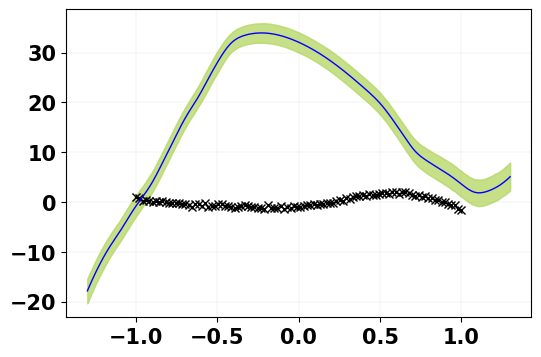

In [166]:
rk, rkc = random.split(rk)
experiment.make_predictions(rkc)
experiment.make_plots().show()

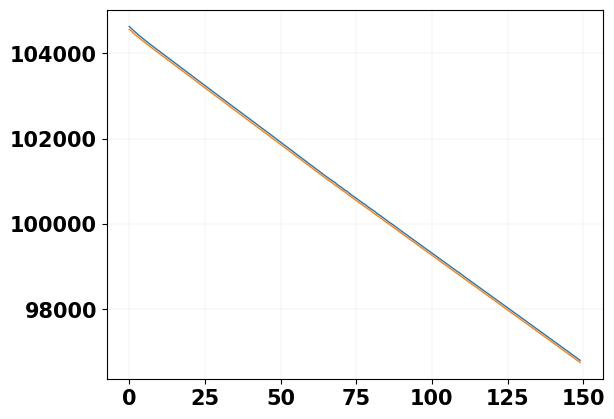

In [131]:
plt.plot(experiment._losses[::(VI_MAX_ITER//50)])
plt.plot(experiment._eval_losses)

In [ ]:
# # Custom train loop
# X, Y = data.train
# guide = experiment._get_guide()
# optimizer = numpyro.optim.Adam(0.002)  # Default taken from ashleve/lightning-hydra-template
# svi = SVI(fresh_bnn, guide, optimizer, TraceMeanField_ELBO(num_particles=1000))
# eval_loss = TraceMeanField_ELBO(num_particles=25000)
#
# init_state = None
# losses = jnp.array([])
# eval_losses = list()
# rng_key = random.PRNGKey(0)
# rng_train, rng_eval = random.split(rng_key)

In [ ]:
# # init_state = svi_state

In [ ]:
# def body_fn(svi_state, _):
#     svi_state, loss = svi.stable_update(svi_state, X=X, Y=Y)
#     return svi_state, loss
#
# if init_state is None:
#     svi_state = svi.init(rng_key, X=X, Y=Y)
# else:
#     svi_state = init_state
# batch = max(VI_MAX_ITER // 50, 1)
# with tqdm.trange(1, VI_MAX_ITER // batch + 1) as t:
#     for i in t:
#         svi_state, batch_losses = lax.scan(body_fn, svi_state, None, length=batch)
#         # svi_state, loss = jit(body_fn)(svi_state, None)
#         losses = jnp.concatenate((losses, batch_losses))
#         valid_losses = [x for x in losses[i - batch :] if x == x]
#         num_valid = len(valid_losses)
#         if num_valid == 0:
#             avg_loss = float("nan")
#         else:
#             avg_loss = sum(valid_losses) / num_valid
#         # Compute full loss
#         rng_eval, rng_eval_curr = random.split(rng_eval)
#         eval_losses.append(eval_loss.loss(rng_eval_curr, svi.get_params(svi_state), fresh_bnn, guide, X=X, Y=Y))
#         t.set_postfix_str(
#             "init loss: {:.4f}, avg. train loss / eval. loss [{}-{}]: {:.4f} / {:.4f}".format(
#                 losses[0], (i-1)*batch, i*batch, avg_loss, eval_losses[-1]
#             ),
#             refresh=False,
#         )
# eval_losses = jnp.stack(eval_losses)

In [ ]:
# plt.plot(losses[::batch])
# plt.plot(eval_losses)

In [ ]:
# experiment._params = svi.get_params(svi_state)

In [ ]:
# experiment.make_predictions(random.PRNGKey(1))
# experiment.make_plots()

In [ ]:

# # svi_results = svi.run(rng_key_train, self._max_iter, stable_update=True,
# #                       progress_bar=(DEVICE != "gpu"), X=X, Y=Y)
# params = svi.get_params(svi_state)
# # print("\nSVI elapsed time:", time.time() - start)
# fig, ax = plt.subplots()
# ax.plot(np.arange(VI_MAX_ITER), losses)
# ax.set_title("ELBO loss during training")
# ax.set_ylim(np.min(losses)*0.9, np.percentile(losses, q=95.0))
# # self._conv_plot = fig, ax
# fig.show()
# # self._params = params

In [ ]:
# preds = experiment._predictions["Y_mean"][..., 0]
# preds.shape

In [ ]:
fig, ax = plt.subplots()
for i in range(10):
    ax.plot(fresh_data.test[0][:, 1], preds[i])
plt.show()

In [ ]:
fig.savefig("figs/posterior_predictive_1.png")

### Sequential experiment

In [ ]:
class SequentialExperiment(SequentialExperimentBlock):
    def __init__(self, bnn: BayesianNeuralNetwork, data: Data, Block: Type[SequentialExperimentBlock],
                 num_inference_steps: int = 2, **block_kwargs):
        """ :param num_inference_steps: split data into this many chunks, and
                                        do Bayesian inference sequentially on them
        """
        super().__init__(bnn, data)
        self._num_inference_steps = num_inference_steps
        self._Block: Type[SequentialExperimentBlock] = Block
        self._block_kwargs: dict = block_kwargs
        # Initialise state
        self._experiment_blocks: list[Block] = list()

    @property
    def posterior(self) -> tuple[dist.Distribution, Optional[dist.Distribution]]:
        assert len(self._experiment_blocks) > 0
        return self._experiment_blocks[-1].posterior

    def train(self, rng_key_train: random.PRNGKey):
        train_len = self._data.train[0].shape[0]
        rng_key_array_train: random.PRNGKeyArray = random.split(rng_key_train, num=self._num_inference_steps)
        for step_idx, rng_key_train_step in enumerate(rng_key_array_train):
            chunk = slice(step_idx*(train_len//self._num_inference_steps),
                          min(train_len, (step_idx+1)*(train_len//self._num_inference_steps)))
            data_view = DataSlice(self._data, chunk)
            experiment_block = self._Block(self._bnn, data_view, **self._block_kwargs)
            experiment_block.train(rng_key_train_step)
            self._bnn = self._bnn.with_prior(*experiment_block.posterior)
            self._experiment_blocks.append(experiment_block)

    def make_predictions(self, rng_key_predict: random.PRNGKey, final_only: bool = True):
        # Delegate to final experiment block
        assert len(self._experiment_blocks) > 0
        if final_only:
            self._experiment_blocks[-1].make_predictions(rng_key_predict)
        else:
            rng_key_array: random.PRNGKeyArray = random.split(rng_key_predict, len(self._experiment_blocks))
            for experiment_block, rng_key in zip(self._experiment_blocks, rng_key_array):
                experiment_block.make_predictions(rng_key)

    def make_plots(self, final_only: bool = True, **kwargs) -> plt.Figure:
        # fig, ax = plt.subplots(nrows=len(self._experiment_blocks))
        assert len(self._experiment_blocks) > 0
        if final_only:
            return self._experiment_blocks[-1].make_plots()
        else:
            for experiment_block in self._experiment_blocks:
                experiment_block.make_plots()
        return None

In [ ]:
class ExperimentWithLastBlockReplaced(Experiment):
    def __init__(self, sequential_experiment: SequentialExperiment, LastBlock: Type[Experiment], **kwargs):
        super().__init__(sequential_experiment._bnn, sequential_experiment._data)
        self._LastBlock: Type[Experiment] = LastBlock
        self._sequential_experiment: SequentialExperiment = sequential_experiment
        self._kwargs = kwargs
        self._last_block: Optional[Experiment] = None

    def train(self, rng_key_train: random.PRNGKey):
        rng_seq, rng_hmc = random.split(rng_key_train)
        self._sequential_experiment.train(rng_seq)
        last_seq_block = self._sequential_experiment._experiment_blocks[-1]
        last_block = self._LastBlock(bnn=last_seq_block._bnn, data=last_seq_block._data, **self._kwargs)
        last_block.train(rng_hmc)
        self._last_block = last_block
        # self._sequential_experiment._experiment_blocks[-1] = last_block

    def make_predictions(self, rng_key_predict: random.PRNGKey, **kwargs):
        rng_seq, rng_hmc = random.split(rng_key_predict)
        self._sequential_experiment.make_predictions(rng_seq, **kwargs)
        self._last_block.make_predictions(rng_hmc)

    def make_plots(self, final_only: bool = True, **kwargs) -> plt.Figure:
        self._sequential_experiment.make_plots(final_only)
        self._last_block.make_plots(**kwargs)

## Space for running experiments

In [ ]:
# fresh_bnn = copy.deepcopy(bnn)
fresh_data = copy.deepcopy(data)
first_half_data = DataSlice(fresh_data, slice(50))
second_half_data = DataSlice(fresh_data, slice(50,100))

In [ ]:
first_half_experiment = BasicMeanFieldGaussianVIExperiment(fresh_bnn, first_half_data, num_samples=1000, max_iter=VI_MAX_ITER)
first_half_experiment.run(random.PRNGKey(0)).savefig("figs/manual_first_half_VI_4.png")
first_half_experiment.show_convergence_plot().savefig("figs/manual_first_half_VI_conv_4.png")

In [ ]:
second_half_HMC_experiment = BasicHMCExperiment(fresh_bnn.with_prior(*first_half_experiment.posterior), second_half_data, num_samples=200, num_warmup=100)
second_half_HMC_experiment.run(random.PRNGKey(0)).savefig("figs/manual_second_half_HMC_4.png")

In [ ]:
second_half_VI_experiment = BasicMeanFieldGaussianVIExperiment(fresh_bnn.with_prior(*first_half_experiment.posterior), second_half_data, num_samples=1000, max_iter=VI_MAX_ITER)
second_half_VI_experiment.run(random.PRNGKey(0)).savefig("figs/manual_second_half_VI_4.png")

In [ ]:
fresh_data = copy.deepcopy(data)

In [ ]:
sequential_experiment = SequentialExperiment(fresh_bnn, fresh_data, BasicMeanFieldGaussianVIExperiment, num_inference_steps=2, max_iter = VI_MAX_ITER)

In [ ]:
sequential_experiment = ExperimentWithLastBlockReplaced(sequential_experiment, BasicHMCExperiment, num_samples=200, num_warmup=100)

In [ ]:
# sequential_experiment.train(random.PRNGKey(0))

In [ ]:
# sequential_experiment.make_predictions(random.PRNGKey(2), final_only=False)

In [ ]:
# sequential_experiment.make_plots(final_only=False)

In [ ]:
# # Custom plotting for sequential experiment
# fig, axs = plt.subplots(figsize=(8, 4), ncols=2)
# for i, ax in enumerate(axs.ravel()):
#     experiment_block = sequential_experiment._sequential_experiment._experiment_blocks[i]
#     predictions = experiment_block._predictions["Y"][..., 0]
#     mean_predictions = experiment_block._predictions["Y_mean"][..., 0]
#     data = experiment_block._data
#     X, Y = data.train
#     X_test, _ = data.test
#     # compute mean prediction and confidence interval around median
#     mean_means = jnp.mean(mean_predictions, axis=0)
#     mean_percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)
#     # plot training data
#     ax.plot(X[:, 1], Y[:, 0], "kx")
#     # plot predictions & quantiles
#     ax.plot(X_test[:, 1], mean_means, color="blue")
#     ax.fill_between(X_test[:, 1], *mean_percentiles, color="lightblue")
#     ax.set_title(str(data._train_idx_slice))
# fig.tight_layout()
# fig.savefig("figs/sequential-VI-simple3.png")

#### Draw samples from prior predictive

In [ ]:
fresh_bnn = copy.deepcopy(bnn)

In [ ]:
fig, ax =  plt.subplots()
with handlers.seed(rng_seed=random.PRNGKey(0)):
    t = data.test[0]
    for _ in range(25):
        prior_fn = handlers.trace(fresh_bnn).get_trace(X=t, Y=None)["Y_mean"]["value"]
        ax.plot(t[:,1], prior_fn)
plt.savefig("figs/prior_pred_4.png")

#### Reverse dataset for two halves sequential experiment

In [ ]:
fresh_bnn = copy.deepcopy(bnn)

In [ ]:
reversed_data = ReverseData(data)

In [ ]:
reversed_sequential_experiment = SequentialExperiment(fresh_bnn, reversed_data, BasicFullRankGaussianVIExperiment)

In [ ]:
# reversed_sequential_experiment.train(random.PRNGKey(0))

In [ ]:
# reversed_sequential_experiment.make_predictions(random.PRNGKey(1), final_only=False)

In [ ]:
# # Custom plotting for reversed sequential experiment
# fig, axs = plt.subplots(figsize=(8, 4), ncols=2)
# for i, ax in enumerate(axs.ravel()):
#     experiment_block = reversed_sequential_experiment._experiment_blocks[i]
#     predictions = experiment_block._predictions["Y"][..., 0]
#     data = experiment_block._data
#     X, Y = data.train
#     X_test, _ = data.test
#     # compute mean prediction and confidence interval around median
#     mean_predictions = jnp.mean(predictions, axis=0)
#     percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)
#     # plot training data
#     ax.plot(X[:, 1], Y[:, 0], "kx")
#     # plot predictions & quantiles
#     ax.plot(X_test[:, 1], mean_predictions, color="blue")
#     ax.fill_between(X_test[:, 1], *percentiles, color="lightblue")
#     ax.set_title(str(data._train_idx_slice))
# fig.tight_layout()
# # fig.savefig("figs/sequential-full-rank-VI-reversed1.png")

#### Randomized dataset experiment

In [ ]:
train_len = data.train[0].shape[0]
random_perm = np.random.choice(np.arange(train_len), size=train_len, replace=False)
permuted_data = PermutedData(data, random_perm)

In [ ]:
# plt.close('all')